In [22]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sys
sys.path.append("../")

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms


from toy_networks.dendrite_linear_mnist import ToyNetwork

from nupic.research.frameworks.continuous_learning.utils import (
    clear_labels,
    freeze_output_layer,
    train_model,
)
from nupic.research.frameworks.continuous_learning.dendrite_layers import (
    DendriteLayer,
)

from nupic.research.frameworks.continuous_learning.mnist_data_utils import combine_classes, mnist_classwise_loader
from nupic.research.frameworks.pytorch.model_utils import evaluate_model

from nupic.torch.modules import (
    Flatten,
    KWinners,
    SparseWeights,
)

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
data_dir = "/home/ec2-user/nta/data/mnist/"

def train_sequential(model, optimizer=None, epochs=1, lr=0.01, combine_data=False, freeze_output=False):
    train_inds = np.arange(4).reshape(2,2)

    if combine_data:
        cats = (False, True)
    else:
        cats = (False, False)
    for j in range(len(train_inds)):
        loader = combine_classes(data_dir, train_inds[j])
        if optimizer is None:  # new optimizer for each bit
            optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=0.)
        for epoch in range(epochs):
            train_model(model, loader=loader, optimizer=optimizer, device=torch.device("cuda"),
                             freeze_output=freeze_output, combine_data=cats[j],
                             output_indices=clear_labels(train_inds[j], len(train_inds.flatten())),
                             layer_type="kwinner", linear_number='',
                            )
            test_acc = np.array(
            [np.round(evaluate_model(model, test_loader[k],
                                 device=torch.device("cuda"))["mean_accuracy"], 2) for k in train_inds.flatten()
            ] )
            print(test_acc)
            
    return test_acc

In [12]:
def heatmap_vals(x, rounding=2, figsize=(10,5)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    img = ax.imshow(x, aspect="auto")
    plt.colorbar(img, ax=ax)
    for (j,i),label in np.ndenumerate(x):
        ax.text(i,j,np.round(label,rounding),ha='center',va='center', color='w')
        
def get_retention_mean(experiment):
    ra = np.vstack(experiment.running_accuracy)[:,1:5]
    old = np.round(ra[1, 2:4].mean(), 2)
    new = np.round(ra[1, 0:2].mean(), 2)
    return old, new

def hard_sigmoid(x):
    return 1 / (1 + torch.exp(-3*(x-1)))

In [118]:
net = ToyNetwork(dpc=10*(1,1,1,1), #1*(1,2,2,2),
                 linear_n=(100, 800, 100,),
                 dend_ws=2*(0.5, 0.1, 0.1, 0.1),
                 cat_ws=(0.1, 0.1, 0.1, 0.1),
                 num_classes=4,
                act_fun_type="kwinner").cuda()

train_loader, test_loader = mnist_classwise_loader()

optim = torch.optim.Adam(net.parameters(), lr=0.02, weight_decay=0.0,)

train_sequential(net, optimizer=optim, lr=0.001, epochs=1, freeze_output=False,  combine_data=True)
# dpc = (1,2,2), size=(200,100,50), SGD, lr=0.01, 2 epochs, no categorical

[1. 1. 0. 0.]
[0.35 0.94 0.   0.04]


array([0.35, 0.94, 0.  , 0.04])

In [124]:
a = tot_acc[:,:,:2].mean(axis=2)
b = tot_acc[:,:,2:].mean(axis=2)

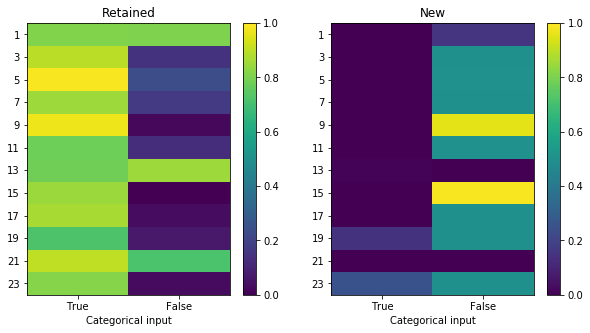

In [125]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(a, aspect="auto")
plt.clim((0, 1))
plt.xticks(range(2), ("True", "False"))
plt.xlabel("Categorical input")
plt.yticks(range(12), dpcs)
plt.title("Retained")
plt.colorbar();

plt.subplot(1,2,2)
plt.imshow(b, aspect="auto")
plt.xticks(range(2), ("True", "False"))
plt.xlabel("Categorical input")
plt.yticks(range(12), dpcs)
plt.title("New")
plt.clim((0, 1))
plt.colorbar();

In [ ]:
dpcs = np.arange(1,24,2)
cat_projection = (True, False)
        
tot_acc = np.zeros((len(dpcs), 2, 4))

for i in range(len(dpcs)):
    for j in range(2):

        net = ToyNetwork(dpc=dpcs[i]*(1,1,1),
                         linear_n=(512, 512, 64,),
                        act_fun_type="kwinner").cuda()

        train_loader, test_loader = mnist_byclass_dataset()

        optim = torch.optim.SGD(net.parameters(), lr=0.04, weight_decay=0.0,)
        
        print("dpc: {}, cat_proj: {}".format(dpcs[i], cat_projection[j]))

        test_acc = train_sequential(net, optimizer=optim, lr=0.02, epochs=1, freeze_output=True,  combine_data=cat_projection[j])

        tot_acc[i,j,:] = test_acc

    


In [122]:
def train_sequential(model, optimizer=None, epochs=1, lr=0.01, combine_data=False, freeze_output=False):
    train_inds = np.arange(4).reshape(2,2)

    if combine_data:
        cats = (False, True)
    else:
        cats = (False, False)
    for j in range(len(train_inds)):
        loader = combine_classes(data_dir, train_inds[j])
        if optimizer is None:  # new optimizer for each bit
            optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=0.)
        for epoch in range(epochs):
            train_model(model, loader=loader, optimizer=optimizer, device=torch.device("cuda"),
                             freeze_output=freeze_output, combine_data=cats[j],
                             output_indices=clear_labels(train_inds[j], len(train_inds.flatten())),
                             layer_type="kwinner", linear_number='',
                            )
            test_acc = np.array(
            [np.round(evaluate_model(model, test_loader[k],
                                 device=torch.device("cuda"))["mean_accuracy"], 2) for k in train_inds.flatten()
            ] )
            print(test_acc)
            
    return test_acc

def combine_classes(data_dir, training_classes, batch_size=32):
    data = []
    for k in training_classes:
        data.append(torch.load(data_dir + "mnist_train_{}.npz".format(k)))

    samples_ = [data[k][0] for k in range(len(training_classes))]
    labels_ = [data[k][1] for k in range(len(training_classes))]
    combined_samples = torch.cat(samples_)
    combined_labels = torch.cat(labels_)
    combined_dataset = list((combined_samples, combined_labels))

    f = tempfile.NamedTemporaryFile(delete=True)
    torch.save(combined_dataset, f)
    dataset = ClasswiseDataset(
        cachefilepath=os.path.split(f.name)[0],
        basename=os.path.split(f.name)[1],
        qualifiers=["tmp"],
        transform=transforms.Compose([
            transforms.Lambda(lambda x: (x[0].float(), x[1].long())),
        ])
    )

    data_loader = DataLoader(
        dataset, batch_size=batch_size, shuffle=True, drop_last=True
    )
    f.flush()

    train_loader = data_loader
    del samples_, labels_, data
    return train_loader
    f.close()

In [63]:
from nupic.research.frameworks.continuous_learning.mnist_data_utils import mnist_byclass_dataset

train_loader, test_loader = mnist_byclass_dataset()

In [64]:
x,y = next(iter(test_loader[0]))

In [66]:
y.shape

torch.Size([32])

In [103]:
np.arange(1,24,2)

array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23])